<a href="https://colab.research.google.com/github/eduardomloureiro/Planejamento/blob/main/Copy_of_Aula_3_Final_Planejamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 3 - Planejamento de Sistemas Elétricos

## PPEE - UFJF

Esta é aula 3 da disciplina de Planejamento de Sistemas Elétricos do PPEE-UFJF

O objetivo desta aula é apresentar uma formulação para a resolução de um problema de despacho hidrotérmico determinístico, ou seja, quando se pressupõe que as vazões às UHEs são conhecidas para todos os estágios ou períodos de planejamento.

A resolução será obtida através de um Programa de Programação Linear Único, ou seja, contemplando todos os estágios.



## Definição dos Dados do Problema

Usinas Hidrelétricas, termelétricas e dados gerais do sistema

In [ ]:
lista_uhe = []

usina = {
    "Nome": "UHE DO MARCATO", # Nome da Usina
    "Vmax": 100.,             # Volume Máximo em hm^3
    "Vmin": 20.,              # Volume Mínimo em hm^3
    "VI": 70,                # Volume Inicial em hm^3
    "Prod": 0.95,             # Produtibilidade em MWmed/hm^3
    "Engol": 60.,             # Engolimento Máximo em hm^3
    "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
            [ 23, 16],
            [ 19, 14],
            [ 15, 11]
    ]
}

lista_uhe.append(usina)

#
# Retirar os comentários abaixo para considerar 2 UHEs
#
#usina = {
#    "Nome": "UHE DO VASCAO",
#    "Vmax": 200.,
#    "Vmin": 40.,
#    "VI": 200,
#    "Prod": 0.85,
#    "Engol": 100.,
#    "Afl": [
#            [ 46, 32],
#            [ 38, 28],
#            [ 30, 22]
#    ]
#}
#lista_uhe.append(usina)

usina = {
    "Nome": "GT_1",     # Nome da Usina Térmica 1
    "Capac": 15.,       # Capacidade Máxima de Geração MWMed
    "Custo": 10.        # Custo de Operação $/MWMed
}

lista_ute = []

lista_ute.append(usina)

usina = {
    "Nome": "GT_2",     # Nome da Usina Térmica 2
    "Capac": 10.,       # Capacidade Máxima de Geração MWmed
    "Custo": 25.        # Custo de Operação $/MWMed
}

lista_ute.append(usina)

#
# d_gerais para o caso 1 UHE
#
d_gerais = {
    "CDef": 500.,             # Custo de Déficit $/MWMed
    "Carga": [ 50., 50., 50.], # Lista com carga a ser atendida por estágio
    "Nr_Disc": 12,            # Número de Discretizações
    "Nr_Est": 3,              # Número de Estágios
    "Nr_Cen": 2               # Número de Cenários de Afluências
}

#
# d_gerais para o caso 2 UHE (Comentar o bloco acima e descomentar o bloco abaixo)
#
#d_gerais = {
#    "CDef": 500.,
#    "Carga": [ 100, 100., 100],
#    "Nr_Disc": 3,
#    "Nr_Est": 3,
#    "Nr_Cen": 2
#}

#
# Cria dicionário de dados com todas as informações do sistema em estudo
#
sistema = {
    "DGer": d_gerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}


# Modelo de Otimização

## Criação de uma Função para o Despacho Hidrotérmico

**Função Objetivo (FOB)**

$		Min \sum_{i=1}^{Nr\_EST} \left( \left( \sum_{j=1}^{Nr\_UTE}  CO_j \cdot gt_{i,j}\right) + CDEF \cdot def_{i} + \left( \sum_{j=1}^{Nr\_UHE}  0.01 \cdot vv_{i,j}\right) \right) $

**sujeito a:**

**Balanço Hídrico (uma restrição para cada estágio $i$ e UHE $j$)**

Caso $ i == 1 $:

$ v_{f_{1,j}} = VI_j + AFL_{1,j} - v_{t_{1,j}} - v_{v_{1,j}} $

Caso $ i \ge 2 $:

$ v_{f_{i,j}} = v_{f_{i-1,j}} + AFL_{i,j} - v_{t_{i,j}} - v_{v_{i,j}} $

**Atendimento à Demanda (uma restrição para cada estágio $i$)**

$ \sum_{j}^{Num\_UHE} \left( \rho_j \cdot v_{t_{i,j}} \right) +
				\sum_{j}^{Num\_UTE}	\left( g_{t_{i,j}} \right) + def_i = CARGA_i $

**Restrições de Canalização:**

Para cada estágio $i$ e UHE $j$:

$VMIN_j \ge v_{f_{i,j}} \ge VMAX_j $

$0 \ge v_{t_{i,j}} \ge ENGOL_j$

$0 \ge v_{v_{i,j}} \ge \infty $

Para cada estágio $i$ e UTE $j$:

$0 \ge g_{t_{i,j}} \ge GTMAX_j $

Para cada estágio $i$:

$ 0 \ge def_i \ge \infty $


In [ ]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op

def pl_unico(sistema, cenario, imprime):

  #
  # Cria função de despacho hidrotérmico
  #

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão Organizadas Matricialmente
  # Exemplo de acesso à variável de decisão de volume final
  # vf[usina][estagio]
  #

  vf = []
  vt = []
  vv = []
  for i,iusi in enumerate(sistema["UHE"]):
    vf.append(variable(sistema["DGer"]["Nr_Est"], "Volume Final na Usina "+iusi["Nome"]))
    vt.append(variable(sistema["DGer"]["Nr_Est"], "Volume Turbinado na Usina "+iusi["Nome"]))
    vv.append(variable(sistema["DGer"]["Nr_Est"], "Volume Vertido na Usina "+iusi["Nome"]))
  gt = []
  for i,iusi in enumerate(sistema["UTE"]):
    gt.append(variable(sistema["DGer"]["Nr_Est"], "Geração na Usina Térmica "+iusi["Nome"]))
  deficit = variable(sistema["DGer"]["Nr_Est"], "Déficit de Energia no Sistema")

  #
  # Construção da Função Objetivo
  #

  fob = 0

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UTE"]):
      fob += iusi['Custo']*gt[i][i_est]

    fob += sistema["DGer"]["CDef"]*deficit[i_est]

    for i, iusi in enumerate(sistema["UHE"]):
      fob += 0.01*vv[i][i_est]

  #
  # Definição das Restrições
  #

  restricoes = []

  #
  # Balanço Hídrico
  #

  for i, iusi in enumerate(sistema["UHE"]):
    for i_est in range(sistema["DGer"]["Nr_Est"]):
      if i_est == 0:
        restricoes.append( vf[i][i_est] == float(iusi["VI"]) + float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est])
      else:
        restricoes.append( vf[i][i_est]  ==  vf[i][i_est-1]  + float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est])

  #
  # Atendimento à Demanda
  #

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    AD = 0
    for i,usi in enumerate(sistema["UHE"]):
      AD += iusi["Prod"]*vt[i][i_est]
    for i,usi in enumerate(sistema["UTE"]):
      AD += gt[i][i_est]
    AD += deficit[i_est]
    restricoes.append( AD == sistema["DGer"]["Carga"][i_est])

  #
  # Restricoes Canalização
  #

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UHE"]):
      restricoes.append(vf[i][i_est] >= iusi["Vmin"])
      restricoes.append(vf[i][i_est] <= iusi["Vmax"])
      restricoes.append(vt[i][i_est] >= 0)
      restricoes.append(vt[i][i_est] <= iusi["Engol"])
      restricoes.append(vv[i][i_est] >= 0)
    for i, iusi in enumerate(sistema["UTE"]):
      restricoes.append(gt[i][i_est] >= 0)
      restricoes.append(gt[i][i_est] <= iusi["Capac"])
    restricoes.append(deficit[i_est] >= 0)

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  #
  # Prepara dicionário de dados com resultados
  #

  lista_uhe = []
  for i, iusi in enumerate(sistema["UHE"]):
    pula = i*sistema["DGer"]["Nr_Est"]
    cma = []
    volf = []
    volt = []
    volv = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      cma.append(restricoes[pula+i_est].multiplier.value[0])
      volf.append(vf[i][iest].value()[0])
      volt.append(vt[i][iest].value()[0])
      volv.append(vv[i][iest].value()[0])
    elemento = {
        "vf": volf,
        "vt": volt,
        "vv": volv,
        "cma": cma
    }
    lista_uhe.append(elemento)

  lista_ute = []
  for i, iusi in enumerate(sistema["UTE"]):
    gerter = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      gerter.append(gt[i][iest].value()[0])
    elemento = {
        "gt": gerter,
    }
    lista_ute.append(elemento)

  pula = Num_UHE*sistema["DGer"]["Nr_Est"]
  cmo = []
  for i_est in range(sistema["DGer"]["Nr_Est"]):
    cmo.append(restricoes[pula+i_est].multiplier.value[0])

  Dger = {
      "CustoTotal": fob.value()[0],
      "CMO": cmo
  }

  resultado = {
    "DGer": Dger,
    "UHE": lista_uhe,
    "UTE": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime:
    print("Custo de Operação de Todos os estágios:", fob.value())

    print("Volume Final por UHE em cada Estágio em (hm^3) ")
    for i,usi in enumerate(sistema["UHE"]):
      print(vf[i])
      print(vt[i])
      print(vv[i])

    print("Geração por UTE em cada Estágio em (MWMed)")
    for i,usi in enumerate(sistema["UTE"]):
      print(gt[i])

    print("Déficit de Energia em cada Estágio em (MWMed)")
    print(deficit)

    print("----- x ------ ")

  return(resultado)


## Programa Principal

Utiliza a função pl_unico e plota gráficos



In [ ]:

resultado = pl_unico(sistema, 0, imprime=False)

print(resultado)






{'DGer': {'CustoTotal': 533.75, 'CMO': [-25.0, -25.0, -25.0]}, 'UHE': [{'vf': [56.15789473684211, 38.315789473684205, 20.0], 'vt': [36.8421052631579, 36.842105263157904, 33.315789473684205], 'vv': [0.0, 0.0, 0.0], 'cma': [23.75, 23.75, 23.75]}], 'UTE': [{'gt': [14.999999999999998, 15.0, 15.0]}, {'gt': [0.0, -7.105427357601002e-15, 3.350000000000005]}]}


## Plota Gráfico das UHEs

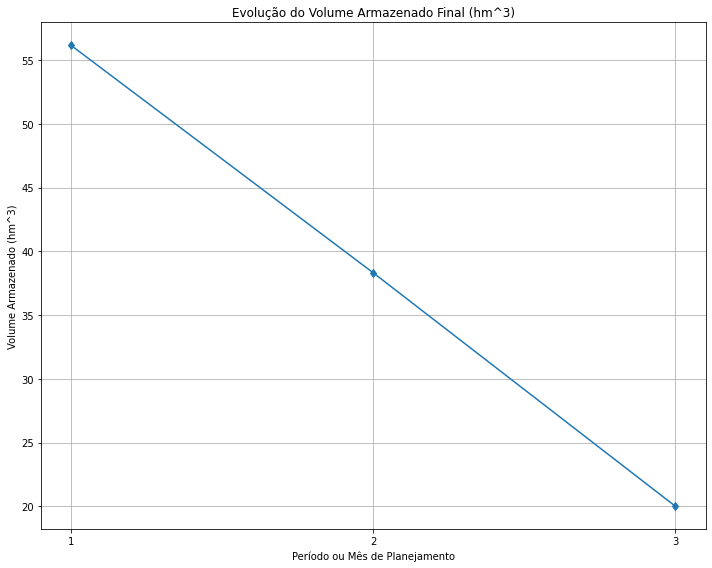

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

for i, iusi in enumerate(resultado["UHE"]):
  plt.plot(x+1, iusi['vf'] , marker='d')
plt.title('Evolução do Volume Armazenado Final (hm^3)')
plt.xlabel('Período ou Mês de Planejamento')
plt.ylabel('Volume Armazenado (hm^3)')
plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.show()

## Plota Gráfico da Geração das UTEs

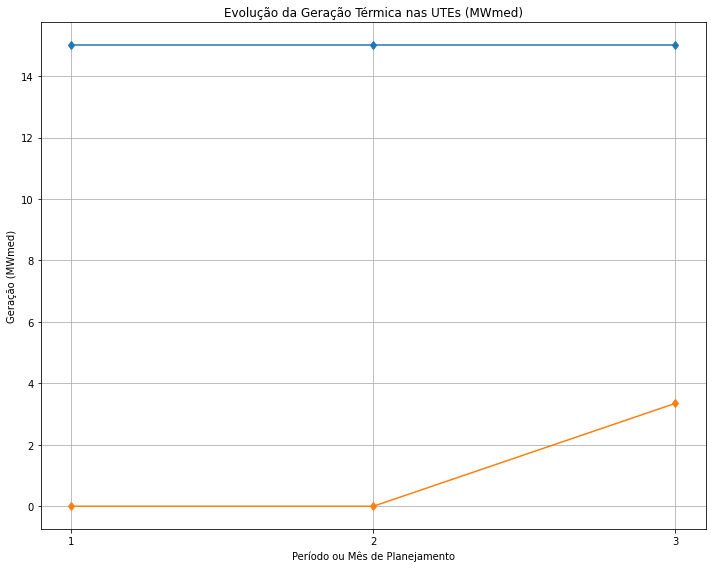

In [ ]:
x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

for i, iusi in enumerate(resultado["UTE"]):
  plt.plot(x+1, iusi['gt'] , marker='d')
plt.title('Evolução da Geração Térmica nas UTEs (MWmed)')
plt.xlabel('Período ou Mês de Planejamento')
plt.ylabel('Geração (MWmed)')
plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.show()